/Users/sangyuxu/Data/MOTSangyu/dump/2018-07-30-GH146-Simultaneous-Green


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


CountLog_2018-07-30_21-31-26.csv
    Chambers Run Odor  Corrected Arousal PI                Genotype  \
1          5   1  OCT             -0.235467  GH146-Gal4>UAS-dGtACR1   
2          6   1  OCT              0.162067  GH146-Gal4>UAS-dGtACR1   
3          7   1  OCT              0.382200  GH146-Gal4>UAS-dGtACR1   
4          8   1  OCT              0.310967  GH146-Gal4>UAS-dGtACR1   
5          9   1  OCT              0.866800  GH146-Gal4>UAS-dGtACR1   
6         10   1  OCT              0.944500        W1118>GH146-Gal4   
7         11   1  OCT              1.000000        W1118>GH146-Gal4   
8         12   1  OCT              0.877900        W1118>GH146-Gal4   
9         13   1  OCT              0.153300        W1118>GH146-Gal4   
10        14   1  OCT              0.333000        W1118>GH146-Gal4   

    Corrected Static PI GenotypeCorrected  
1              0.826800              Test  
2              0.580067              Test  
3              0.966667              Test  
4        

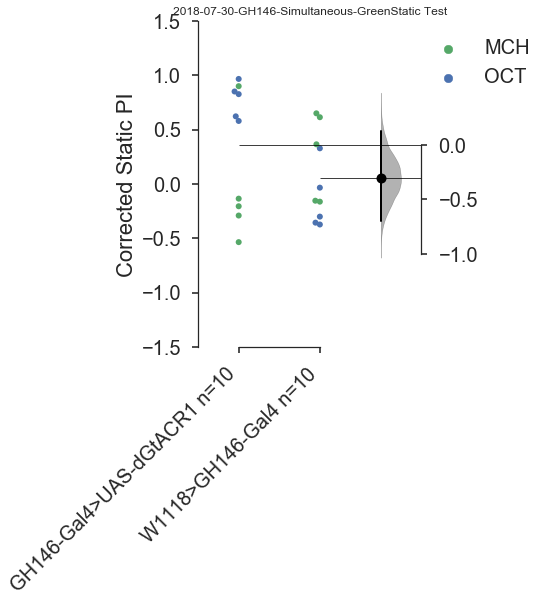

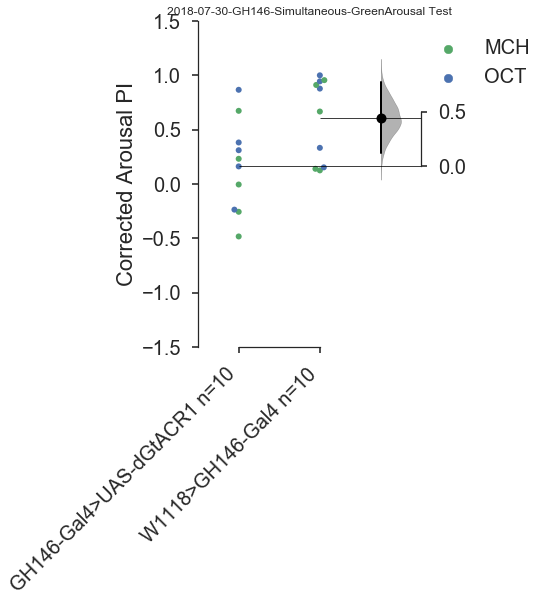

In [90]:
# this is a modification to Stan's code to extract PI from MOT2. 
# changes: 
# 1. it finds the metadata file and reads it, uses information in the metadata to plot and annotate outputs 
# 2. it finds the last 30 seconds of arousal test (assuming there is only one arousal test episode) and computes
# the PI of that period
# 3. it plots arousal PI grouped by and colored by user defined categories (but see notes near the bottom).
# 4. future versions will also include: statitc test PI; arousal test PI for multiple episodes as in trace cond. 
# 5. future versions will be wrapped nicely in functions. 
# windows users should change the direction of the slashes i think

import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm as cm
import csv
import dabest
import seaborn as sns
%matplotlib inline

import os
currentPath = os.getcwd()
flagSwitchGenotype=False
##~~~~~~~~~~~~~~~~~ Windows users: Change the direction of slashes in the section below~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# the following line finds the sample data folder in the same folder as the code
# 2018-07-22-CS-Simultaneous-Green is an example of tests done with only CS files
# OK107Trace is an example of multiple sessions with 3 genotypes

datapath=currentPath+"/MOT2SampleData/2018-07-22-CS-Simultaneous-Green"
datapath=currentPath+"/MOT2SampleData/OK107Trace"

# or user can define the path to data folder by uncommenting the following line
datapath="/Users/sangyuxu/Data/MOTSangyu/dump/2018-07-30-GH146-Simultaneous-Green"

experimentName=datapath.rsplit('/', 1)[-1]
if 1*("summary" in os.listdir(datapath))==0:
    os.mkdir(datapath + '/summary')
summaryFolderPath=datapath + '/summary/'
##~~~~~~~~~~~~~~~~~ Windows users: Change the direction of slashes in the section above~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

print (datapath)
filenames = os.listdir(datapath)
filenames.sort()
#finds the countlogs here
countlogs= [s for s in filenames if "CountLog" in s]
#finds the metadata files here
metadatas = [s for s in filenames if "MetaData" in s]

PIdfAllDay=[];
minStaticTestIndex=1
#proceses each countlog in alphabetical
for i in range(0, len(countlogs)):
    f = countlogs[i]
    m = 'MetaData'+ f[8:]
    df = pd.read_csv(datapath+'/'+f, error_bad_lines=False)
    dfMeta = pd.read_csv(datapath+'/'+m, error_bad_lines=False)

    #finds the bits in the countlogs that are arousal tests
    arousalTestIndex=[i for i, e in enumerate(df.ExperimentState) if "Arousal" in e]
    #picks out the last 30 data points (which at 1fps is 30 seconds) in future versions this should be made a function of framerate
    last30secArousal = df.loc[arousalTestIndex[-30:]]
    PIArousalAll=last30secArousal.filter(regex= "Ch"+str(5)+"_PI_r")
    
    for chamber in range(6, 15):
        last30secArousalDF = last30secArousal.filter(regex= "Ch"+str(chamber)+"_PI_r")
        PIArousalAll["Ch"+str(chamber)+"_PI_r"] =last30secArousalDF.values    
    PIallArousalAverage = PIArousalAll.mean(axis=0)
    PIallArousalAverage.values[np.flatnonzero(1*dfMeta.Odor[4:15]=='MCH')] = 0- PIallArousalAverage.values[np.flatnonzero(1*dfMeta.Odor[4:15]=='MCH')]

    GenotypeList=['Control Gal4', 'Control UAS', 'Test', 'CS']
    GenotypeNumber = 1*dfMeta.Genotype.str.contains('Gal4')+2*dfMeta.Genotype.str.contains('UAS')+4*dfMeta.Genotype.str.contains('CS')    
    PIresults={'Chambers':np.arange(5,15), 'Run':str(i+1), 'Odor':dfMeta.Odor[4:15],
               'Corrected Arousal PI':PIallArousalAverage.values.T,  
               'Genotype':dfMeta.Genotype[4:15], 'GenotypeNumber':GenotypeNumber[4:15]}

    #finds the bits in the countlogs that are arousal tests
    staticTestIndex=[i for i, e in enumerate(df.ExperimentState) if "Static" in e]
    if len(staticTestIndex) !=0:
        #picks out the last 30 data points (which at 1fps is 30 seconds) in future versions this should be made a function of framerate
        last30secStatic = df.loc[staticTestIndex[-30:]]
        PIStaticAll=last30secStatic.filter(regex= "Ch"+str(5)+"_PI_r")

        for chamber in range(6, 15):        
            last30secStaticDF = last30secStatic.filter(regex= "Ch"+str(chamber)+"_PI_r")
            PIStaticAll["Ch"+str(chamber)+"_PI_r"] =last30secStaticDF.values
        PIallStaticAverage = PIStaticAll.mean(axis=0)
        PIallStaticAverage.values[np.flatnonzero(1*dfMeta.Odor[4:15]=='MCH')] = 0- PIallStaticAverage.values[np.flatnonzero(1*dfMeta.Odor[4:15]=='MCH')]
        PIresults={'Chambers':np.arange(5,15), 'Run':str(i+1), 'Odor':dfMeta.Odor[4:15],
               'Corrected Arousal PI':PIallArousalAverage.values.T,  
               'Genotype':dfMeta.Genotype[4:15], 'GenotypeNumber':GenotypeNumber[4:15], 'Corrected Static PI':PIallStaticAverage.values.T}
    PIdf=pd.DataFrame(data=PIresults)
    PIdf.index=range(1, 11)
   


    GenotypeCorrected=[GenotypeList[PIdf.loc[i].GenotypeNumber-1] for i in range(1, 11)]
    PIdf=PIdf.assign(GenotypeCorrected = GenotypeCorrected)        
    PIdf=PIdf.drop(['GenotypeNumber'], axis=1)
    # the following lines save the average and raw PIs as .csv into a folder called 'summary' created in the original data folder
    PIdf.to_csv(summaryFolderPath + 'averagePI' + f[8:-4] + '.csv', sep=',', index=True, index_label = None)
    PIall.to_csv(summaryFolderPath + 'rawPI'+ f[8:-4] + '.csv', sep=',', index=True)
    PIdfAllDay.append(PIdf)
    print(f)
    print(PIdf)
    print('Mean PI' + str(np.mean(PIallArousalAverage.values.T)))
    minStaticTestIndex = np.min([minStaticTestIndex, len(staticTestIndex)])
PIdfAllDay=pd.concat(PIdfAllDay)
PIdfAllDay.index=range(1, len(PIdfAllDay)+1)

if flagSwitchGenotype:
    uniqueGenotypeIdx=np.unique(PIdfAllDay.GenotypeCorrected, return_index=True)[1]
    GenotypeLabels=[PIdfAllDay.loc[j+1].GenotypeCorrected for j in uniqueGenotypeIdx]
    genotypeToUse='GenotypeCorrected'
else:
    GenotypeLabels=np.unique(PIdfAllDay.Genotype)
    genotypeToUse='Genotype'

uniqueRunIdx=np.unique(PIdfAllDay.Run, return_index=True)[1]
RunLabels=[PIdfAllDay.loc[k+1].Run for k in uniqueRunIdx]
uniqueOdorIdx=np.unique(PIdfAllDay.Odor, return_index=True)[1]
odorLabels=[PIdfAllDay.loc[j+1].Odor for j in uniqueOdorIdx]
    
if minStaticTestIndex !=0:
    if len(GenotypeLabels)>1: # if there are different genotypes in the metadata, more commonly encountered in tests
        StaticFig, StaticB = dabest.plot(PIdfAllDay,
                               x=genotypeToUse, # the default for this test config is to group flies by genotype
                               y='Corrected Static PI',
                               color_col='Odor',# and color by odor
                               swarm_ylim =(-1.5,1.5),
                               fig_size=(4,6),
                               idx=GenotypeLabels,
                               paired=False
                              )
    else: # if there is only one genotype in the metadata, commonly encountered if just test equipment with CS flies
        StaticFig, StaticB = dabest.plot(PIdfAllDay,
                               x='Odor', # if just one type of flies, group by odor. This can also be "Run" 
                                          #which is the session/file in chronological sequence
                               y='Corrected Static PI',
                               swarm_ylim =(-1.5,1.5),
                               fig_size=(4,6),
                               idx=odorLabels, # this has to correspond to the value of x above. if x is 'Run', idx has to be 'RunLabels'
                               paired=False
                              )
    # print(b)
    plt.title(experimentName + 'Static Test')   

if len(GenotypeLabels)>1: # if there are different genotypes in the metadata, more commonly encountered in tests
    ArousalB, ArousalB = dabest.plot(PIdfAllDay,
                           x=genotypeToUse, # the default for this test config is to group flies by genotype
                           y='Corrected Arousal PI',
                           color_col='Odor',# and color by odor
                           swarm_ylim =(-1.5,1.5),
                           fig_size=(4,6),
                           idx=GenotypeLabels,
                           paired=False
                          )
else: # if there is only one genotype in the metadata, commonly encountered if just test equipment with CS flies
    ArousalB, ArousalB = dabest.plot(PIdfAllDay,
                           x='Odor', # if just one type of flies, group by odor. This can also be "Run" 
                                      #which is the session/file in chronological sequence
                           y='Corrected Arousal PI',
                           swarm_ylim =(-1.5,1.5),
                           fig_size=(4,6),
                           idx=odorLabels, # this has to correspond to the value of x above. if x is 'Run', idx has to be 'RunLabels'
                           paired=False
                          )
plt.title(experimentName + 'Arousal Test')   
# print(b)
# the following line saves the figure into a folder called 'summary' created in the original data folder
plt.savefig(summaryFolderPath+ 'Contrast' + f[8:-4] + '.png', bbox_inches='tight', dpi = 300)


In [86]:
 np.min([minStaticTestIndex, len(staticTestIndex)])

0

False